In [2]:
from os import system
from glob import glob

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

pd.options.display.max_rows = 5000
pd.options.display.max_colwidth = 300

In [206]:
def gather_data():
    url = "https://ar.wikipedia.org/wiki/%D9%82%D8%A7%D8%A6%D9%85%D8%A9_%D9%85%D8%AD%D8%A7%D9%81%D8%B8%D8%A7%D8%AA_%D8%A7%D9%84%D8%B3%D8%B9%D9%88%D8%AF%D9%8A%D8%A9"
    _, _, *locations_df_list = pd.read_html(url)
    locations_df_list = locations_df_list[:13]
    
    provinces = [
#         "Riyadh",
        "Makkah",
        "Madinah",
        "Buraydah",
        "Dammam",
        "Abha",
        "Tabuk",
        "Ha'al",
        "Arar",
        "Jazan",
        "Najran",
        "Alba'hah",
        "Sakaka"
    ]

    geos = [
#         (24.721540, 46.705117),
        (21.422719, 39.825616),
        (24.468361, 39.610744),
        (26.338439, 43.966748),
        (26.412899, 50.071757),
        (18.215544, 42.502229),
        (28.394034, 36.570041),
        (27.516989, 41.697790),
        (30.977227, 41.024822),
        (16.889081, 42.569220),
        (20.011137, 41.465389),
    ]
    
    for province, geo in zip(provinces, geos):
        system(f'twint -g="{geo[0]},{geo[1]},2km" -o "data/{province}_big.csv" --csv')
        
# gather_data()

In [4]:
csvs = [path for path in glob("data/*") ]
dfs = [(csv[csv.rfind("\\")+1:csv.rfind(".")], pd.read_csv(csv, sep="\t")) for csv in csvs]

C:\Softwarez\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Softwarez\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [207]:
for province, df in dfs:
    df["province"] = province
    
provs = pd.concat([df for _, df in dfs])
provs["date"] = pd.to_datetime(provs.pop('date') + " " + provs.pop('time'))

In [208]:
coords = provs["place"].dropna().apply(eval).apply(lambda coord: coord["coordinates"]) # Get coords
provs_loc = provs.iloc[coords.index]
provs_loc["lat"], provs_loc["lon"] = list(zip(*coords.values))

<ipython-input-208-ba0c556d8516>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



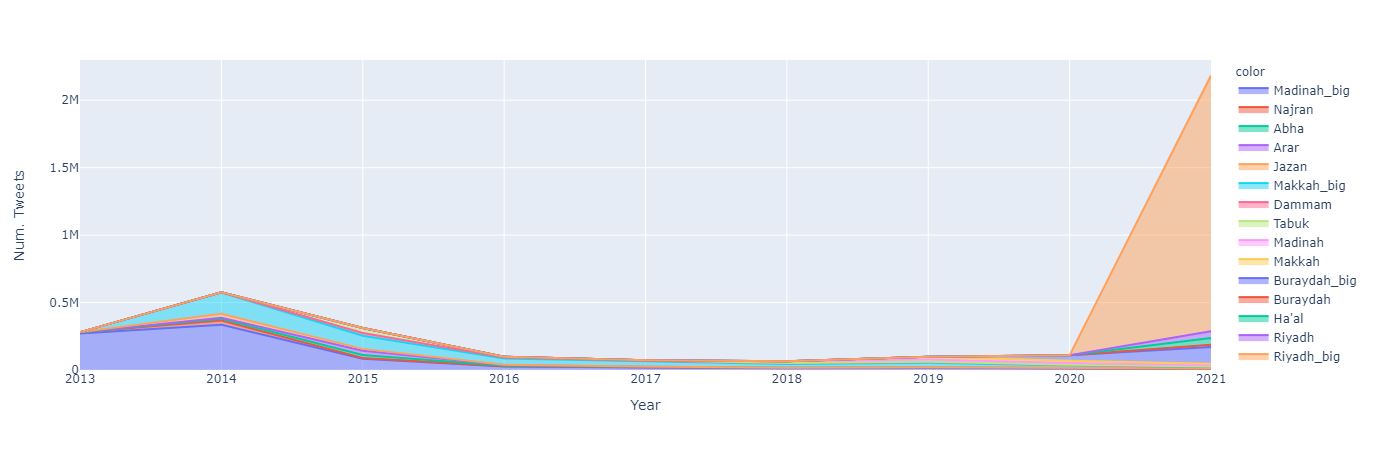

In [209]:
tweets_by_year = provs.groupby([provs.date.dt.year, "province"]).size()
years, names = list(zip(*tweets_by_year.index))
px.area(x=years, y=tweets_by_year.values, color=names, labels={"x": "Year", "y": "Num. Tweets"})

# Graph is weird. Why is all Riyadh_big tweets just one year ago?

In [216]:
province = provs_loc.groupby("province").get_group("Madinah_big")

In [218]:
fig = px.density_mapbox(province, lat=province["lat"], lon=province["lon"], radius=10, hover_name="tweet",
                        mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()
fig.write_html("Madinah.html", auto_open=True)

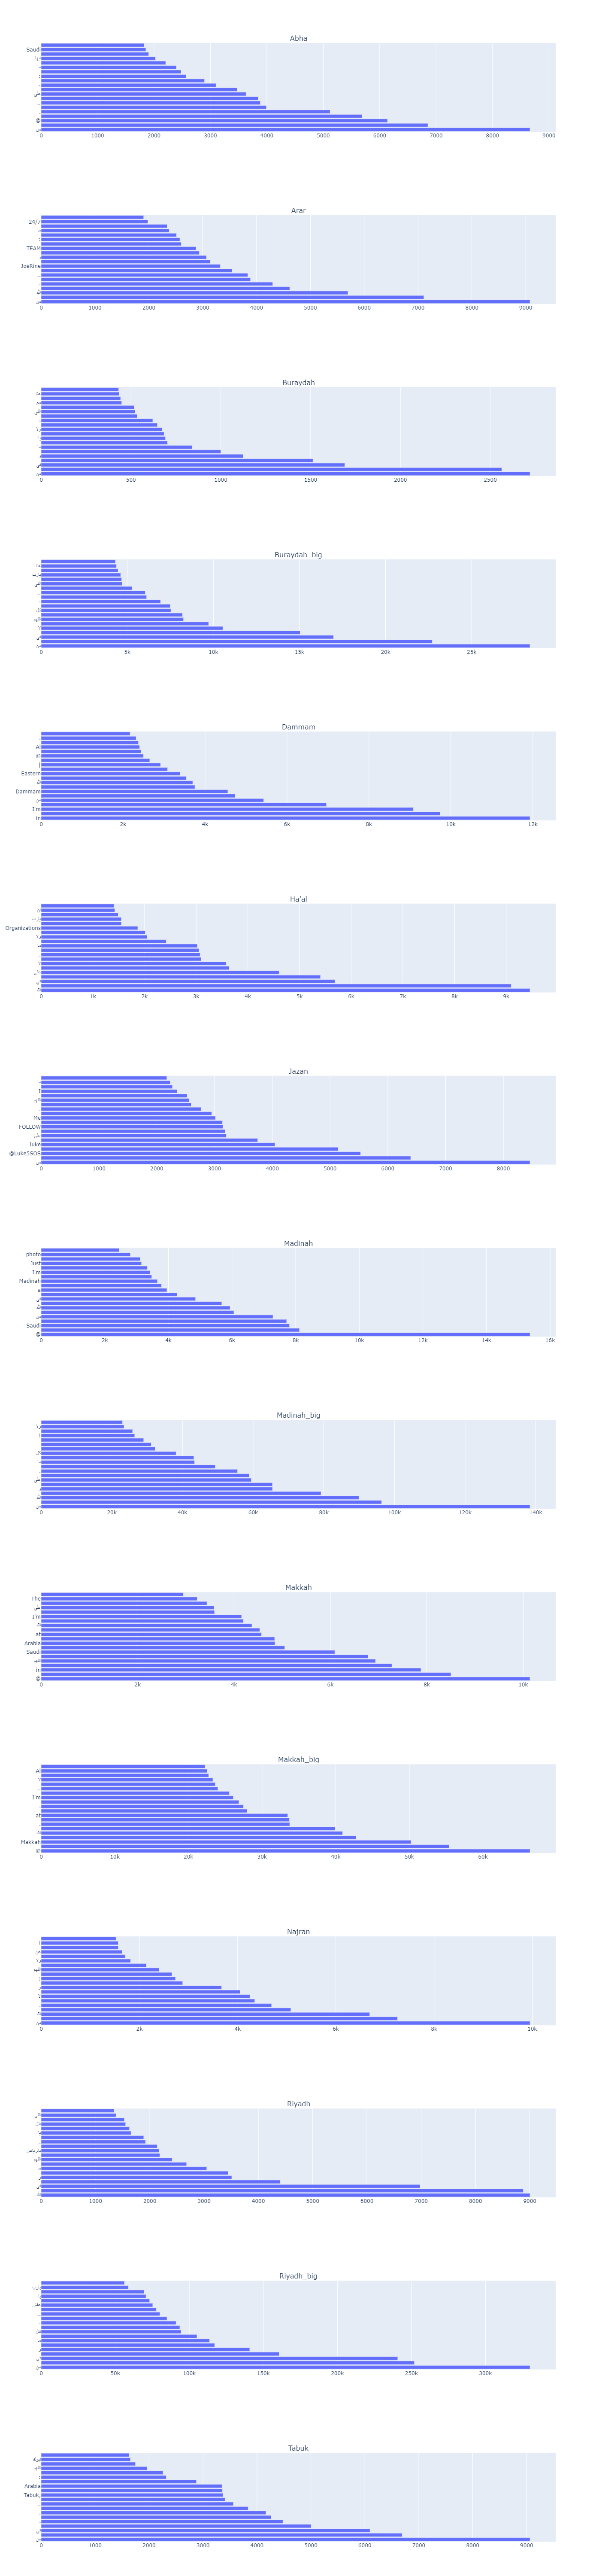

In [77]:
from collections import Counter

figs = []
titles = []

for name, province in provs.groupby("province"):
    words = " ".join(province["tweet"].values).split()
    counter = Counter(words)
    num, word = list(zip(*counter.most_common(20)))

    figs.append(px.bar(x=word, y=num))
    titles.append(name)
    
    
subplot = make_subplots(rows=len(figs), subplot_titles=titles)
for i, fig in enumerate(figs):
    subplot.add_trace(
        next(fig.select_traces(0)),
        row=i+1, col=1
    )
    
subplot.update_layout({"height": 6000})

<ipython-input-78-0fa1b12f5ecc>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-78-0fa1b12f5ecc>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-78-0fa1b12f5ecc>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-78-0fa1

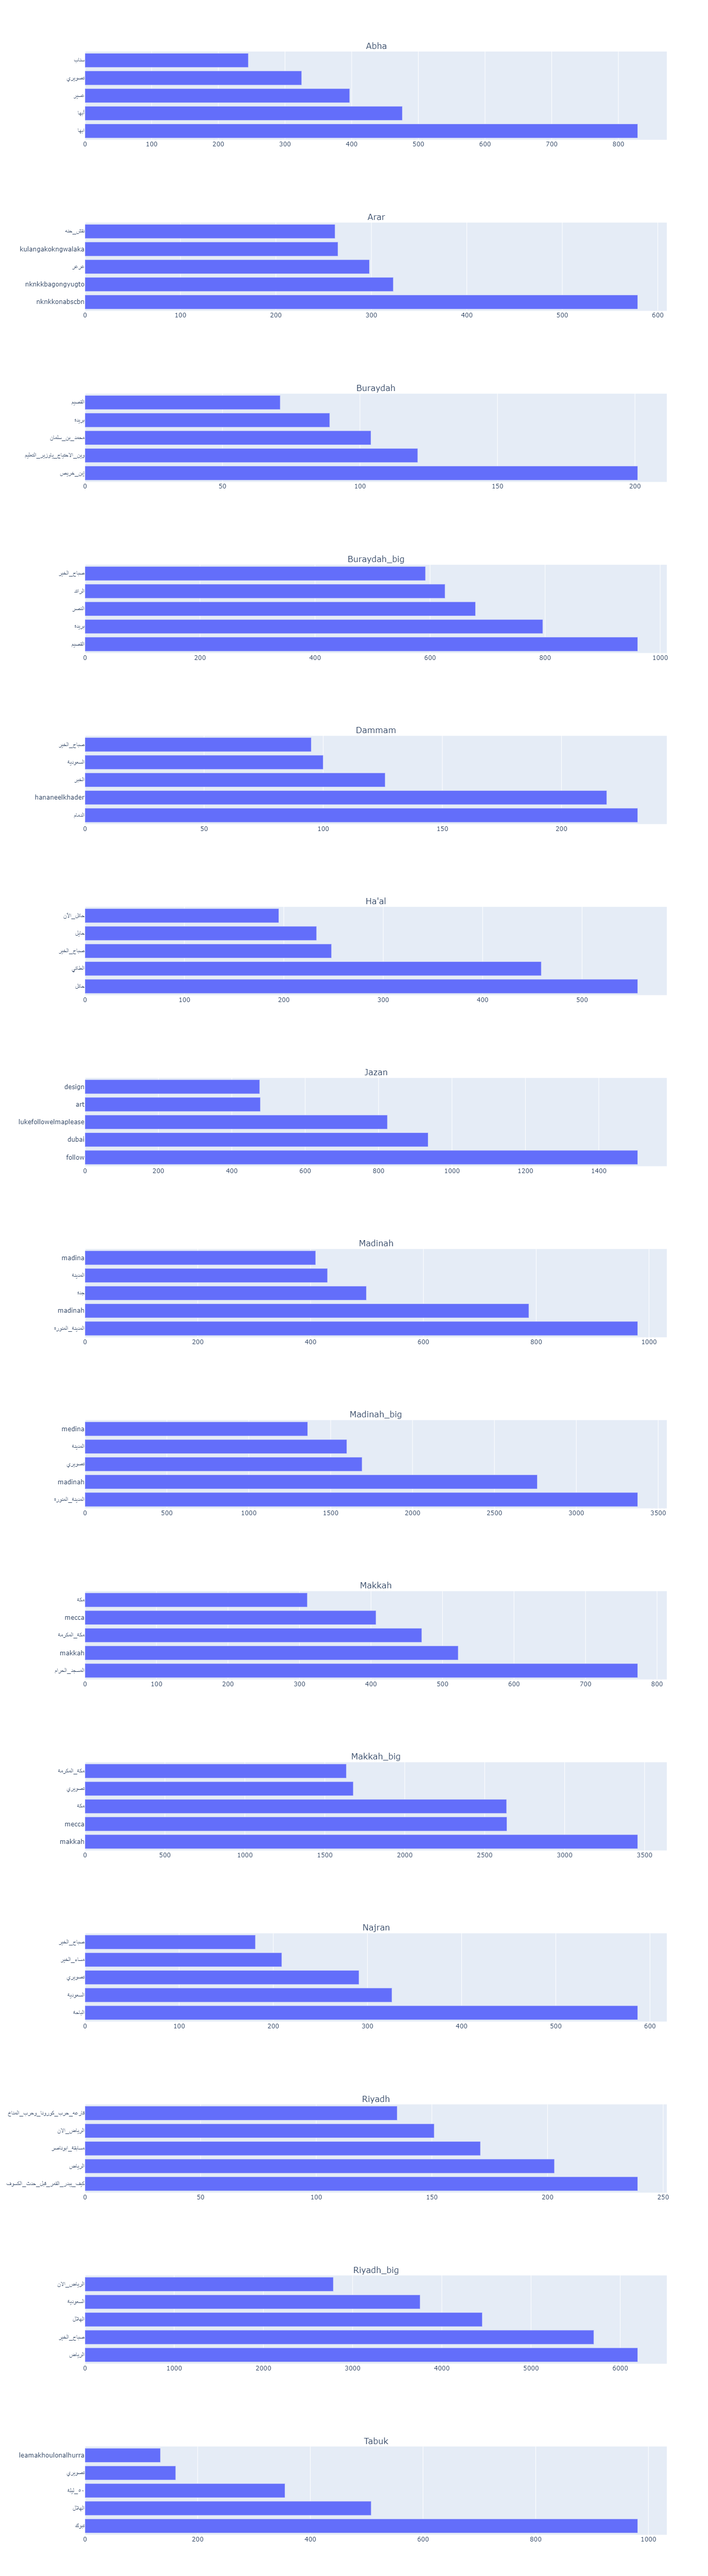

In [78]:
from collections import Counter

figs = []
titles = []

for name, province in provs.groupby("province"):
#     if "big" in name:
#         continue
        
    province["hashtags"] = province["hashtags"].apply(eval) # Eval
    province = province[province["hashtags"].apply(len) != 0] # Filter empty
    province["hashtags"] = province["hashtags"].apply(lambda t: " ".join(t)) # Join tags to str
    hashtags = " ".join(province["hashtags"].values).split() # Get all tags
    counter = Counter(hashtags)
    num, hashtag = list(zip(*counter.most_common(5)))

    figs.append(px.bar(x=hashtag, y=num))
    titles.append(name)
    
    
subplot = make_subplots(rows=len(figs), subplot_titles=titles)
for i, fig in enumerate(figs):
    subplot.add_trace(
        next(fig.select_traces(0)),
        row=i+1, col=1
    )
    
subplot.update_layout({"height": 5000})

In [79]:
from collections import Counter

figs = []

for name, province in provs.groupby("province"):
    province = province.groupby("language").size().nlargest(10)

    figs.append(px.pie(names=province.index, values=province.values, title=name))

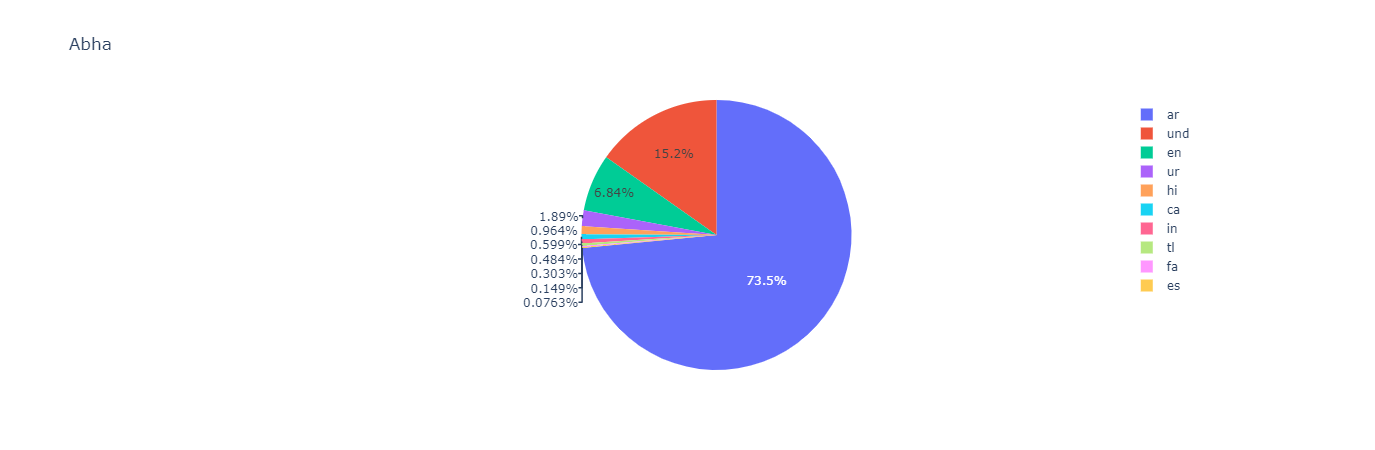

In [80]:
figs[0]

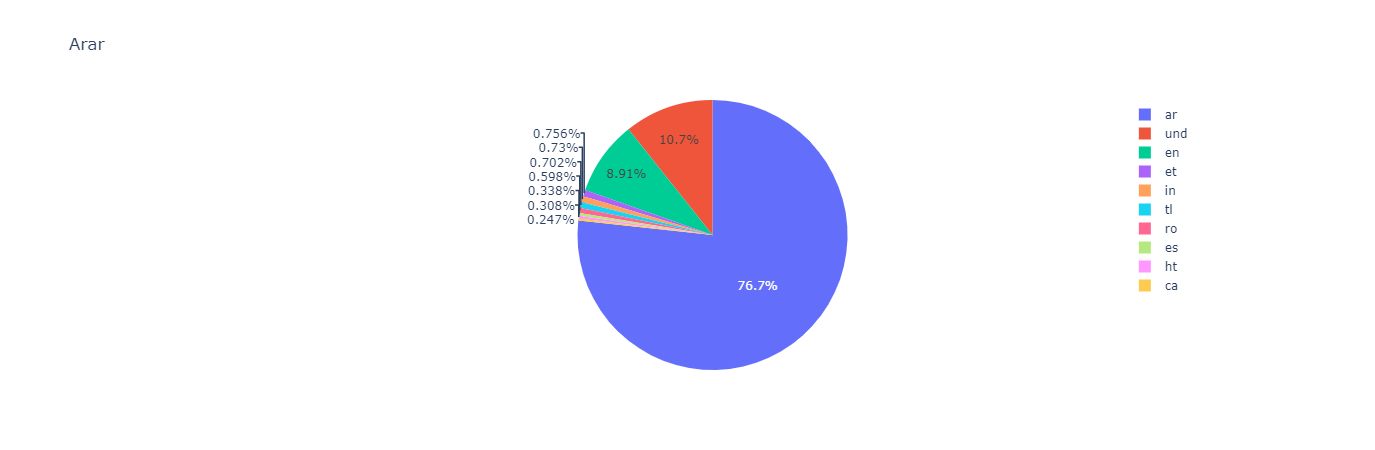

In [81]:
figs[1]

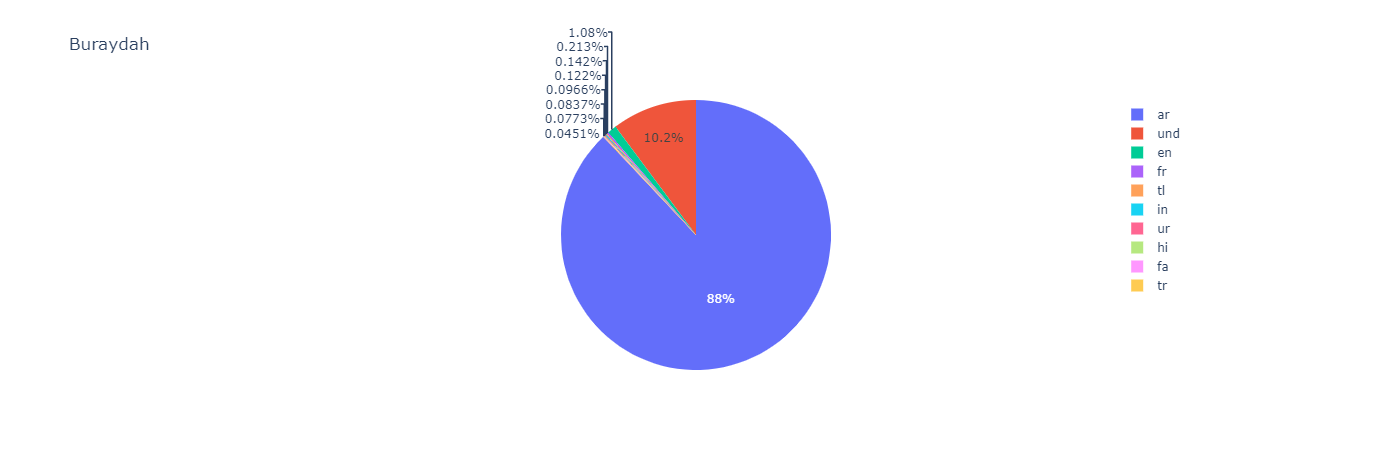

In [82]:
figs[2]

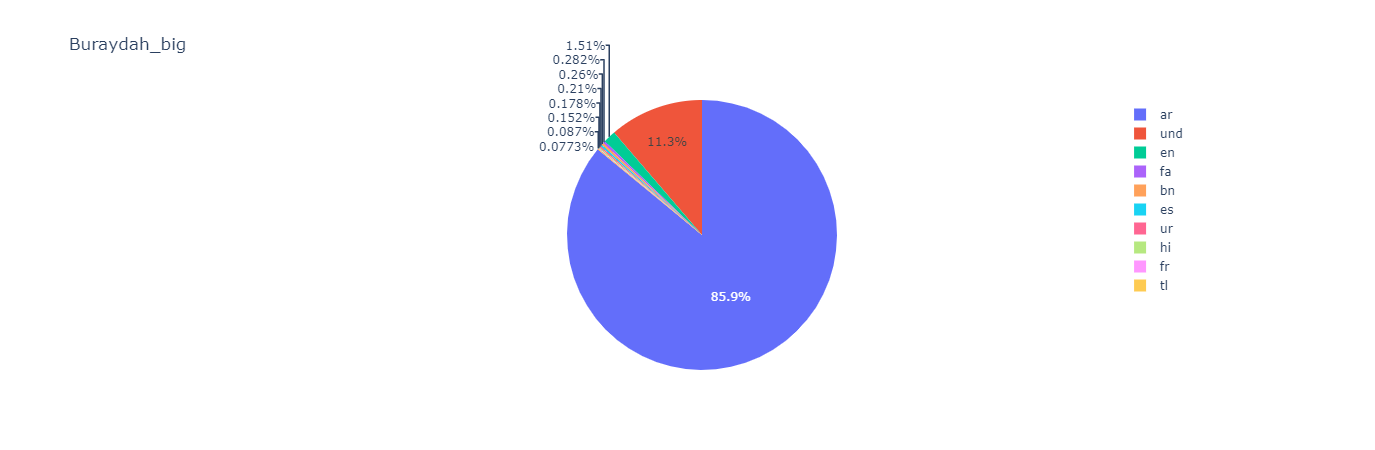

In [83]:
figs[3]

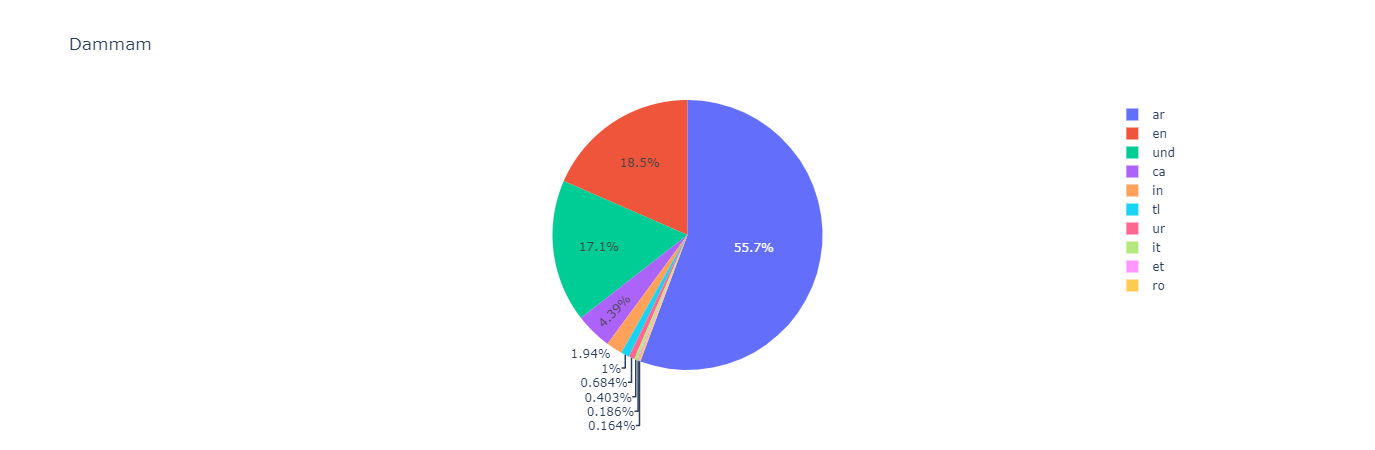

In [84]:
figs[4]

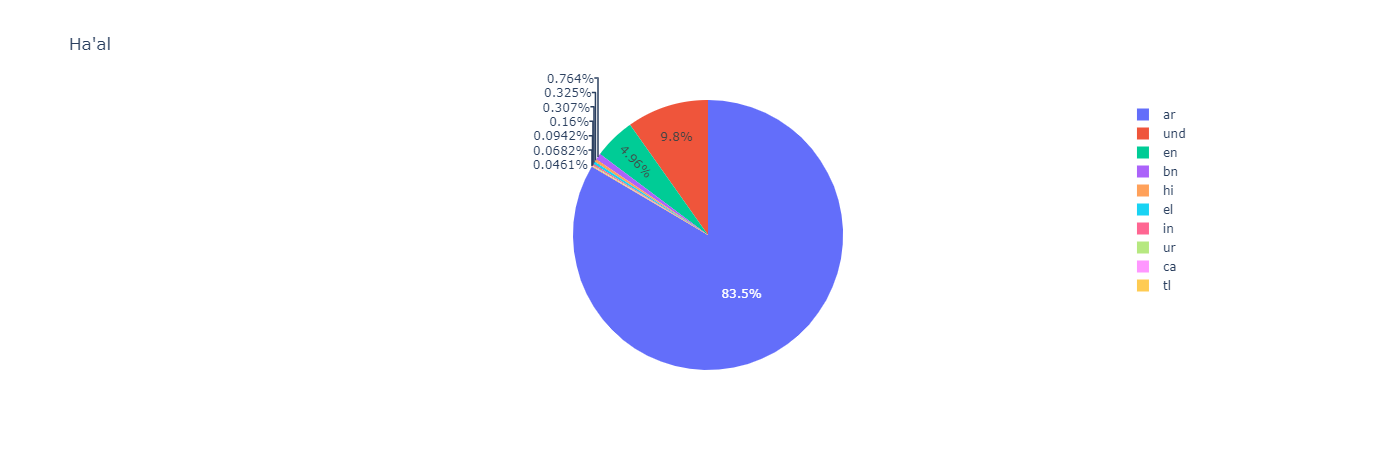

In [85]:
figs[5]

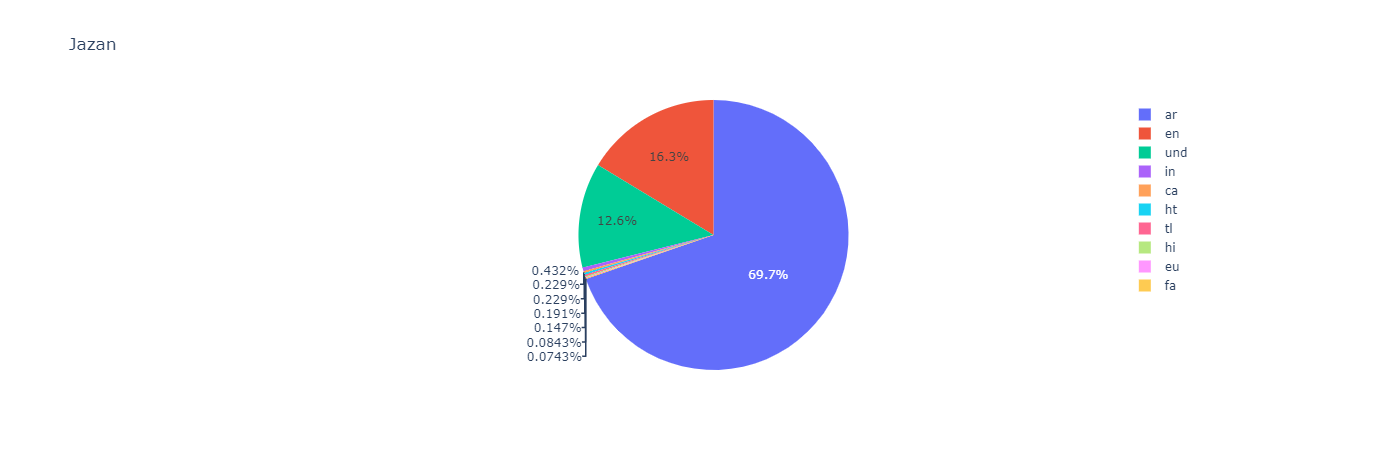

In [86]:
figs[6]

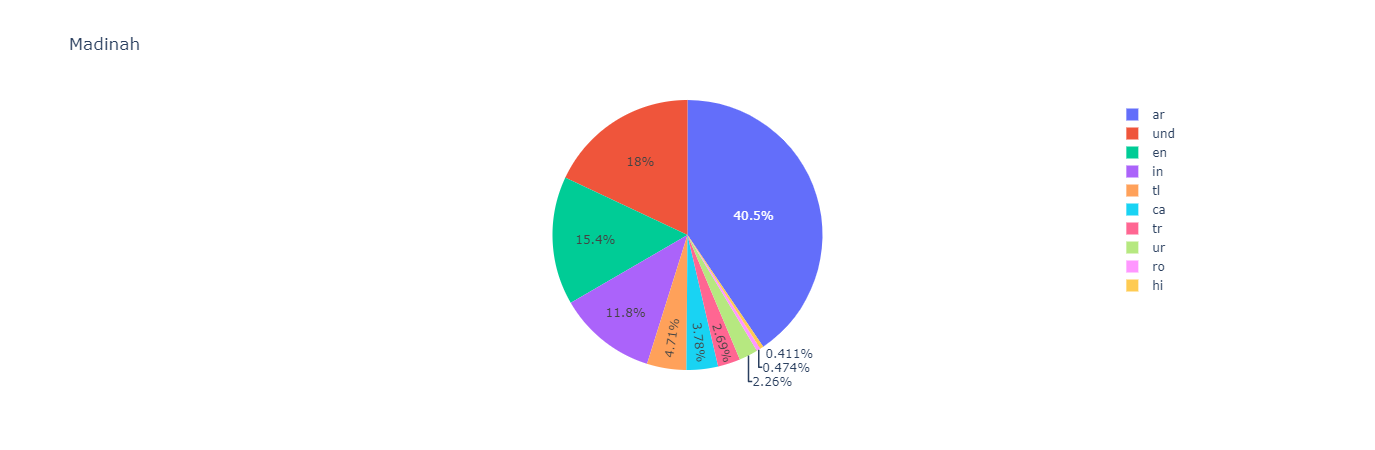

In [87]:
figs[7]

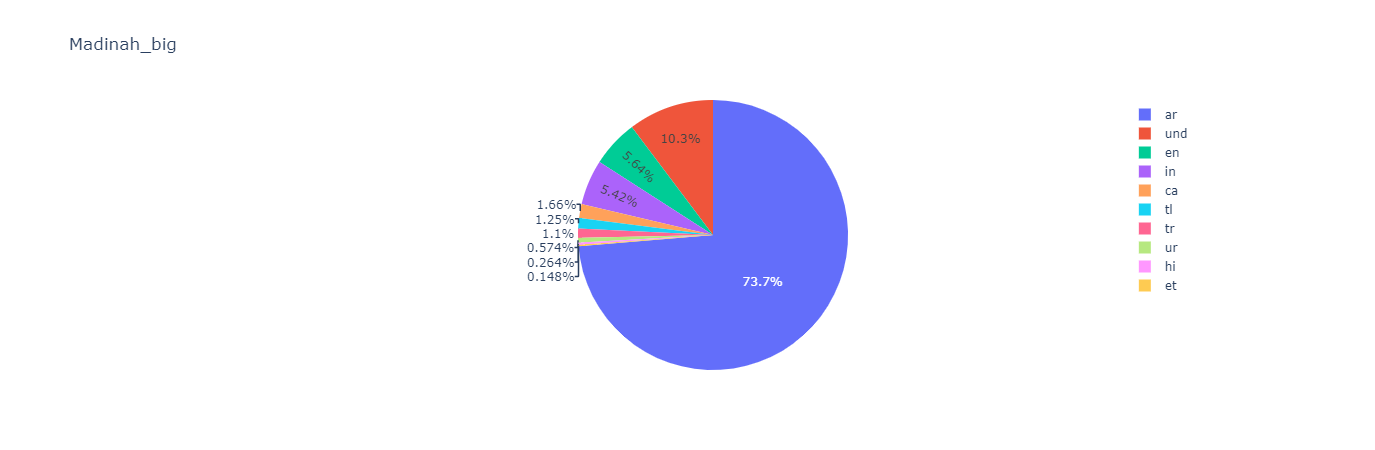

In [88]:
figs[8]

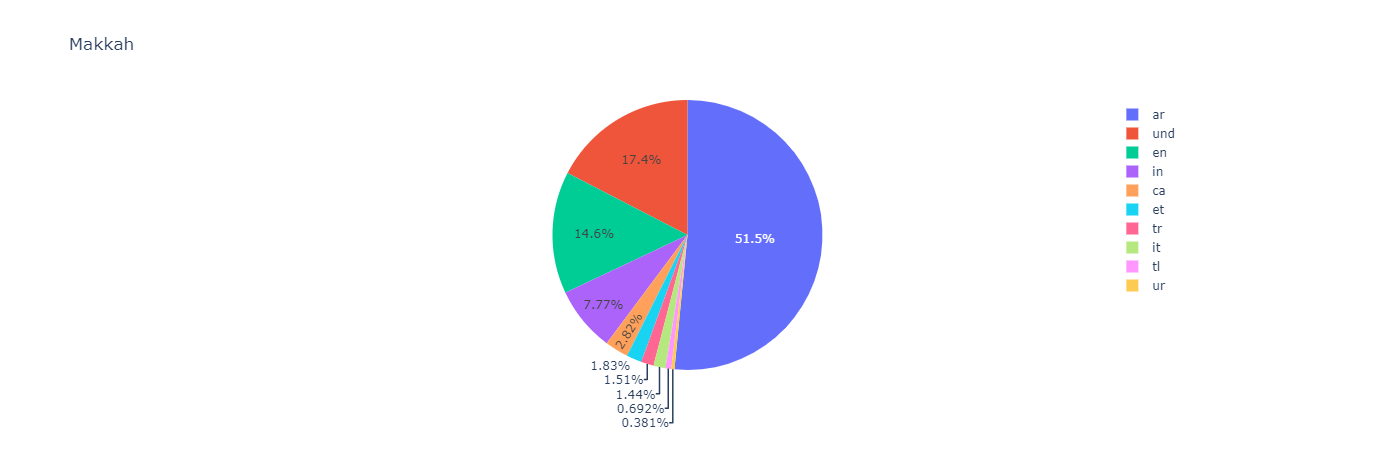

In [89]:
figs[9]

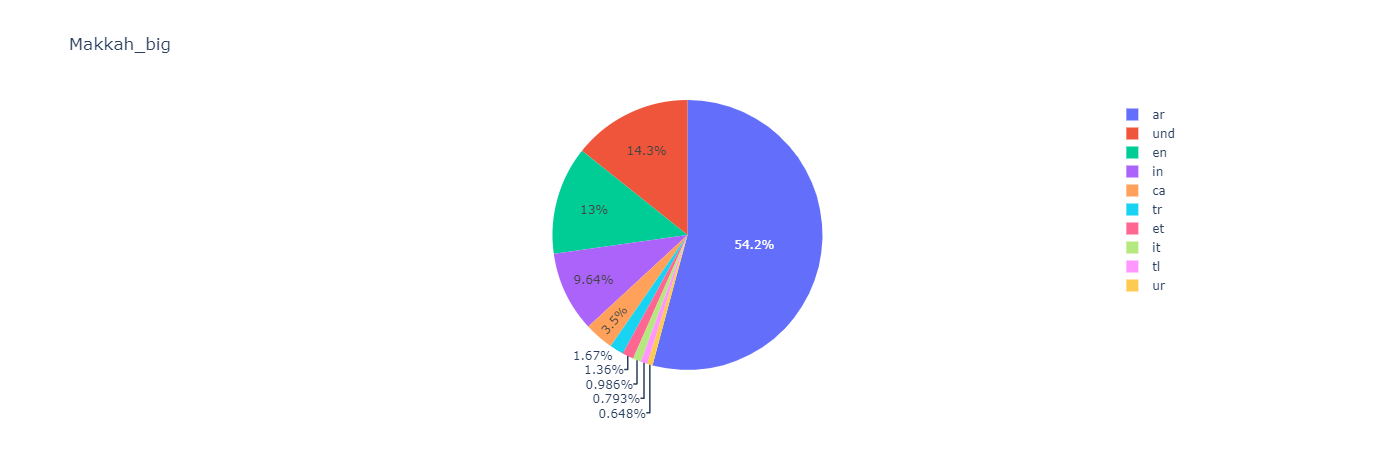

In [90]:
figs[10]

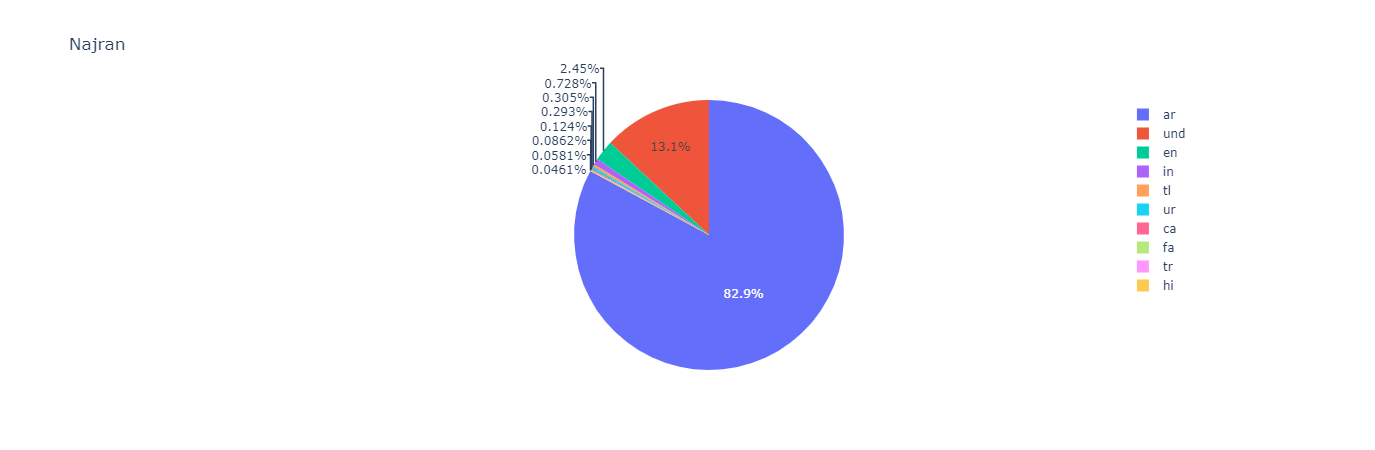

In [91]:
figs[11]

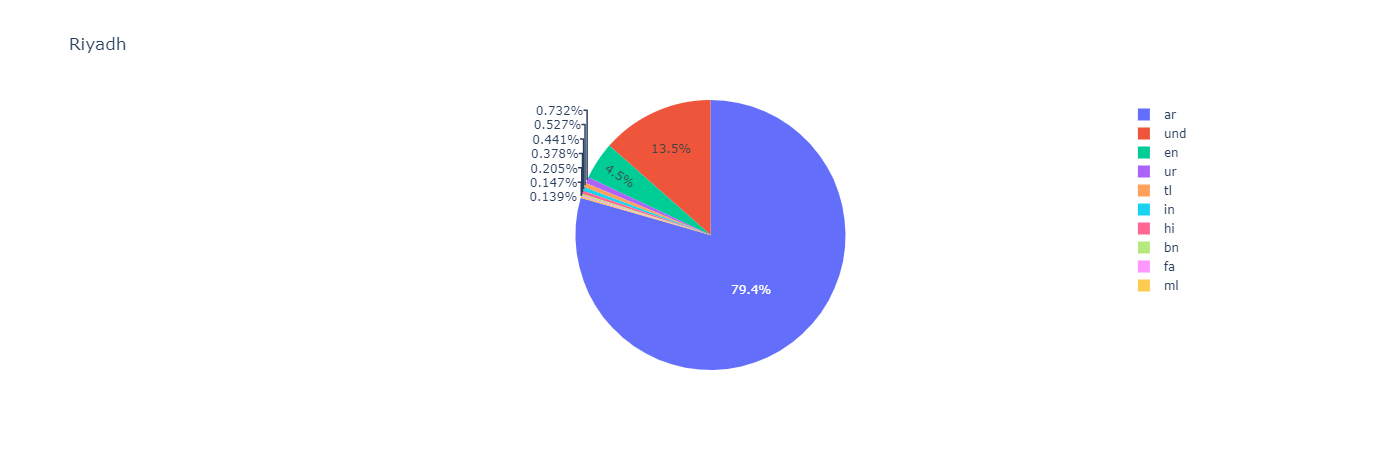

In [92]:
figs[12]

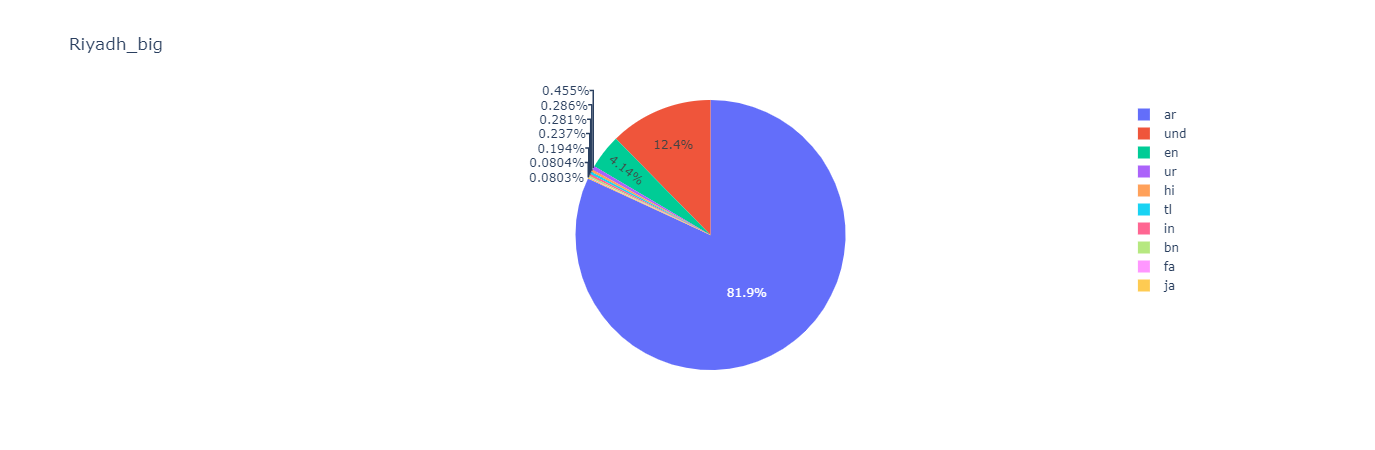

In [93]:
figs[13]

In [98]:
provs_loc.columns

Index(['id', 'conversation_id', 'created_at', 'timezone', 'user_id',
       'username', 'name', 'place', 'tweet', 'language', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'thumbnail',
       'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id',
       'reply_to', 'retweet_date', 'translate', 'trans_src', 'trans_dest',
       'province', 'date', 'lat', 'lon'],
      dtype='object')

In [191]:
qurey = "جامعة الملك سعود"
provs[provs["tweet"].str.contains(qurey)][["tweet", "name", "username", "link"]].iloc[:10]

,tweet,name,username,link
15889,صورة من #الأرشيف تم التقاطها عام ١٤٢٨هـ حينما كنت مشاركاً مع فرقة جوالة جامعة الملك سعود لاستقبال… https://t.co/neUDOwBeHh,#عـ بـ د ا لـ مـ جـ يـ د_آ ل_مـ و سـ ـى ⚖,a_majeedmousa,https://twitter.com/a_majeedmousa/status/648881873339465728
2098,نبارك للدكتورة ريم بنت محمد تعيينها أستاذ مساعد بكلية الطب بجامعة الملك سعود الف مبروك ابوثامر وإلى المراتب الاعلى ان شاء الله @alanazy111,عبدالعزيز السلطاني,alsultany85,https://twitter.com/alsultany85/status/847210031598723072
4587,الدكتور علي دبكل العنزي رئيساً لقسم الإعلام في كلية اﻵداب بجامعة الملك سعود https://t.co/BFls4xiHk3,عبدالعزيز السلطاني,alsultany85,https://twitter.com/alsultany85/status/772846806036250624
6280,ابارك لﻷستاذ محمد غازي بتخرج ابنه مهند من كلية الهندسة بجامعة الملك سعود مبروك أبو مهند مبروك مهند @alanazy111 https://t.co/PevLwIG43z,عبدالعزيز السلطاني,alsultany85,https://twitter.com/alsultany85/status/731552764577353728
32326,@Saud_me2008 هذه الصوره ستكون على جدران ملعب جامعة الملك سعود #مرسول_بارك و تُعنون بـ (أصالة مفقوده غابت مع السيول) لا أستبعد ذلك عليهم فالمهم لديهم أن أكون مثل #الهلال أو شبيهه,عبد الرحمن المهوس,almohawisad9,https://twitter.com/AlmohawisAd9/status/1397372047714566151
52922,@Ruh_Rd @nic_riyadh @SAMA_Oil @enoc_Ksa @DallahHospitals الجواب: جامعة الملك سعود. #مسابقة_طرق_الرياض13,💖 Hhtoon 💖,hhtoon5,https://twitter.com/Hhtoon5/status/1386070343421468673
74974,يستاهل النجم الخُلوق محمد السهلاوي هذا التكريم من لدّن التعاونيين بعد حصوله على درجة الماجستير من جامعة الملك سعود وابو ابراهيم نموذج جميل وقدوة حسنة خُلقياً وفنياً وعلمياً ، وشكراً لمن كان خلف هذا التكريم . @Sahlawi_m10 https://t.co/lSge8JsbNp,الوحيد,weeehd,https://twitter.com/weeehd/status/1372601664042119176
109157,#وظائف_عن_بعد #وظائف_شاغرة #وظائف_القصيم #وظايف #عاجل #وظائف_نسائية #جامعة_القصيم توفر #وظائف_تعليمية وفنية شاغرة للرجال والنساء بجامعة الملك سعود التقديم 👇🏻👇🏻 https://t.co/O5ATlPCdj6,﮼ارتِــــوَاء ❃ #وظائف_شاغرة .,ertwwa_4,https://twitter.com/ertwwa_4/status/1353445708125233152
127202,@majjed_80 @saudi_dr وما يحتاجونه في أثناء الدراسة ،وقد خطت جامعة الملك سعود،في هذا خطوات عظيمة ،أرجو أن يستفاد منها وتطبق في جميع جامعاتنا,أم البراء البارقية,om_albraa3,https://twitter.com/om_albraa3/status/589736708897312770
241062,قامت جامعة الملك سعود باصدار مصحف اضغط على الرابط ويتحمل المصحف عندك ويتم قلب الصفحات بلمس الشاشه من اليسار لليمين https://t.co/Q2OYaiC4lI,ابوفراس,nasseralsobhy,https://twitter.com/nasseralsobhy/status/515874505831362562


In [162]:
qurey = "Design|Art"
links = provs[provs["tweet"].str.contains(qurey, regex=True)]["photos"].unique()[:10]

In [184]:
urls = []
for link in links:
    if len(link) != 0:
        urls.append(eval(link))

In [185]:
urls = np.concatenate(urls)

In [ ]:
import requests
for i, url in enumerate(urls):
    response = requests.get(url)
    
    extention = url[url.rfind(".") + 1:]
    with open(f"data/images/{i}.{extention}", "wb+") as file:
        file.write(response.content)